In [1]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

In [2]:
# Function to compute LBP features for a single pixel
def compute_lbp_pixel(img, x, y, radius=1, n_points=8):
    lbp_value = local_binary_pattern(img[x - radius: x + radius + 1, y - radius: y + radius + 1], n_points, radius, method='uniform')
    return int(np.max(lbp_value))

# Function to compute LBP features for the entire image
def compute_lbp_image(image, radius=1, n_points=8):
    lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')
    return lbp_image


In [3]:
# Data directories for different classes
class_directories = {
    'Cyst': '/kaggle/input/kidney-ct-scan-clahe/Cyst',
    'Normal': '/kaggle/input/kidney-ct-scan-clahe/Normal',
    'Stone': '/kaggle/input/kidney-ct-scan-clahe/Stone',
    'Tumor': '/kaggle/input/kidney-ct-scan-clahe/Tumor'
}


In [4]:
# List to store LBP features and corresponding labels
lbp_features = []
labels = []

In [5]:
# Iterate over each class directory
for class_label, directory in class_directories.items():
    # List all image files in the directory
    image_files = [os.path.join(directory, file) for file in os.listdir(directory)]
    
    # Extract LBP features for each image and store them in the list
    for image_file in image_files:
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        lbp_feature = compute_lbp_image(image)
        lbp_features.append(lbp_feature.ravel())
        labels.append(class_label)

In [6]:
# Convert lists to numpy arrays
lbp_features = np.array(lbp_features)
labels = np.array(labels)

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lbp_features, labels, test_size=0.2, random_state=42)

In [8]:
# Initialize the Support Vector Machine classifier
svm_classifier = SVC(probability=True, random_state=42)

In [9]:
# Fit the classifier on the training data
svm_classifier.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [10]:
# Predict the labels for the test data
y_pred = svm_classifier.predict(X_test)

In [11]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8995983935742972


In [12]:
# Generate and print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.93      0.96      0.95       765
      Normal       0.85      1.00      0.92      1015
       Stone       1.00      0.56      0.72       276
       Tumor       0.96      0.77      0.85       434

    accuracy                           0.90      2490
   macro avg       0.93      0.82      0.86      2490
weighted avg       0.91      0.90      0.89      2490



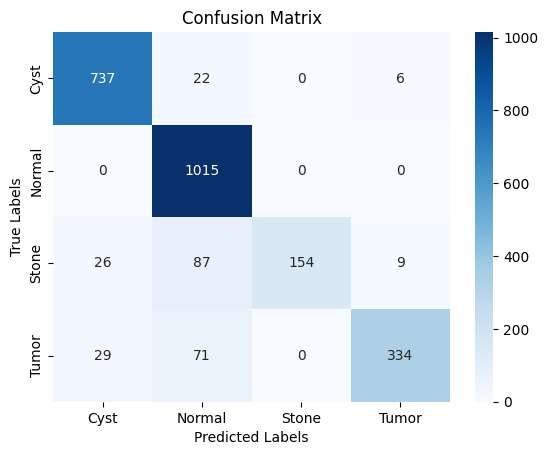

In [13]:
# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_directories.keys(), yticklabels=class_directories.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


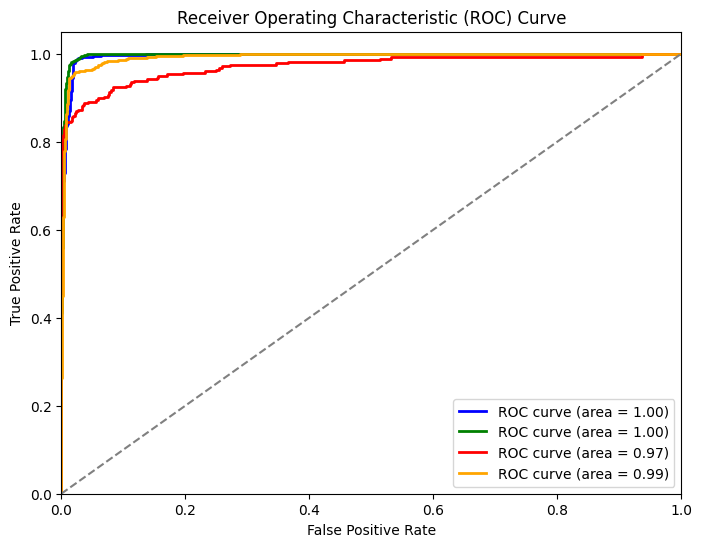

In [14]:
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=['Cyst', 'Normal', 'Stone', 'Tumor'])

# Predict probabilities for each class
y_score = svm_classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()